# Mapping Occurance of High Winds

In [245]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_data.grid_manager import pluck_point_new

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b\n%d')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

In [2]:
m = draw_CONUS_HRRR_map()

### Get lat/lon grid from file for plotting

In [3]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

## Get OSG field

In [168]:
def get_field_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE, STAT = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT].value
    except:
        #print "COULD NOT GET", FILE
        return np.nan

------

# Summarize the statistics
i.e. How often are the 95th percentile winds greater than 8 m/s?

In [235]:

var = 'UVGRD:10 m'
stat = 'p95'
threshold = 10

hours = range(24)
#hours = [18]

months = [9,10,11]


##### Additional setup

In [236]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)


days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Dates (with leap year)
DAYS = days[months[0]-1:months[-1]]
HOURS = np.sum(DAYS)*24 # number of days times 24
DATES = np.array([datetime(2016, sDATE.month, sDATE.day) + timedelta(hours = h) for h in range(HOURS)])
DATES = DATES[::24/len(hours)] # in case we don't request all 24 hours


In [237]:
args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, month, day, hour), stat ]\
            for month in months for day in range(1,days[month-1]+1) for hour in hours]

In [238]:
args[0]

['/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/UVGRD_10_m/OSG_HRRR_UVGRD_10_m_m09_d01_h00_f00.h5',
 'p95']

In [239]:
cpu = multiprocessing.cpu_count()
chunks = range(0, len(args), cpu)
chunks.append(len(args))
print chunks

[0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600, 624, 648, 672, 696, 720, 744, 768, 792, 816, 840, 864, 888, 912, 936, 960, 984, 1008, 1032, 1056, 1080, 1104, 1128, 1152, 1176, 1200, 1224, 1248, 1272, 1296, 1320, 1344, 1368, 1392, 1416, 1440, 1464, 1488, 1512, 1536, 1560, 1584, 1608, 1632, 1656, 1680, 1704, 1728, 1752, 1776, 1800, 1824, 1848, 1872, 1896, 1920, 1944, 1968, 1992, 2016, 2040, 2064, 2088, 2112, 2136, 2160, 2184]


In [240]:
fill_array = np.zeros_like(lat)
count = len(args)
for i, chunk in enumerate(chunks[:-1]):
    MP_args = args[chunks[i]: chunks[i+1]]
    p = multiprocessing.Pool(cpu)
    these_fields = np.array(p.map(get_field_MP, MP_args))
    p.close()
    gte_thresh = these_fields >= threshold
        
    fill_array += np.sum(gte_thresh, axis=0)
    
    print chunk,

0 24 48 72 96 120 144 168 192 216 240 264 288 312 336 360 384 408 432 456 480 504 528 552 576 600 624 648 672 696 720 744 768 792 816 840 864 888 912 936 960 984 1008 1032 1056 1080 1104 1128 1152 1176 1200 1224 1248 1272 1296 1320 1344 1368 1392 1416 1440 1464 1488 1512 1536 1560 1584 1608 1632 1656 1680 1704 1728 1752 1776 1800 1824 1848 1872 1896 1920 1944 1968 1992 2016 2040 2064 2088 2112 2136 2160


In [241]:
count

2184

In [242]:
occurance = (fill_array/count)*100

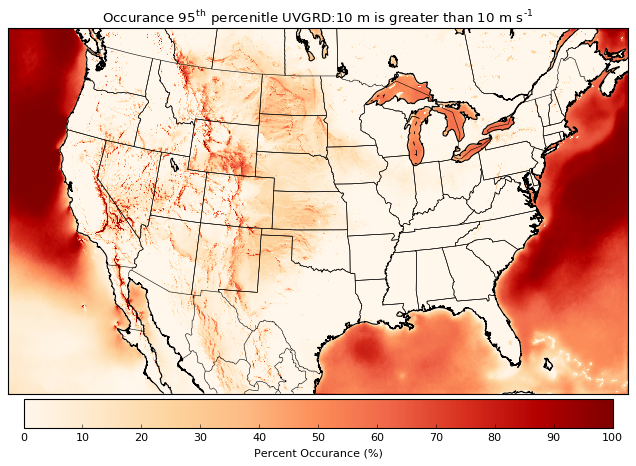

In [267]:
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(lon, lat, occurance,
             cmap= 'OrRd',
             latlon=True)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent Occurance (%)')

plt.title(r'Occurance %s$\mathregular{^{th}}$ percenitle %s is greater than %s m s$\mathregular{^{-1}}$' % (stat[1:], var, threshold))

plt.savefig('./figs/occurance_UVGRD10m_p95_ALLHOURS_SON')


In [244]:
np.save('occurance_UVGRD_10m_p95_ALLHOURS_SON', occurance)

In [283]:
period = 'SON'
a = np.load('occurrence_UVGRD_10m_p95_ALLHOURS_%s.npy' % period)

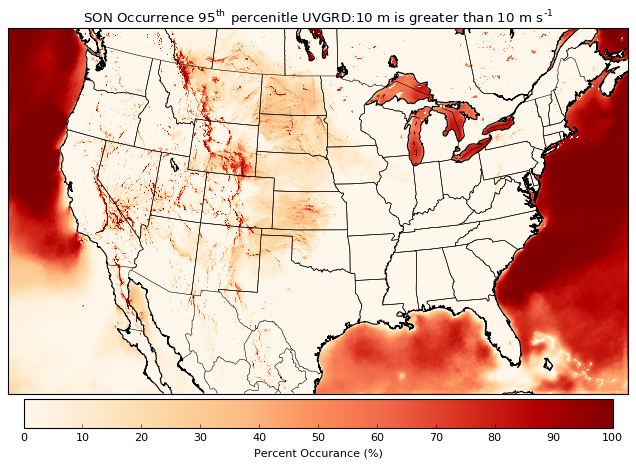

In [284]:
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.pcolormesh(lon, lat, a,
             cmap= 'OrRd',
             latlon=True)

cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent Occurance (%)')

plt.title(r'%s Occurrence %s$\mathregular{^{th}}$ percenitle %s is greater than %s m s$\mathregular{^{-1}}$' % (period, stat[1:], var, threshold))

plt.savefig('./figs/occurrence_UVGRD10m_p95_ALLHOURS_%s' % period)